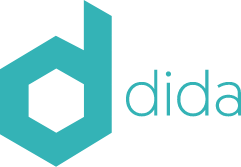

Hello dear Dida Team!

 Welcome to my application task! I used the classical U-NET network structure as described in  [[1]](https://arxiv.org/pdf/1505.04597.pdf)
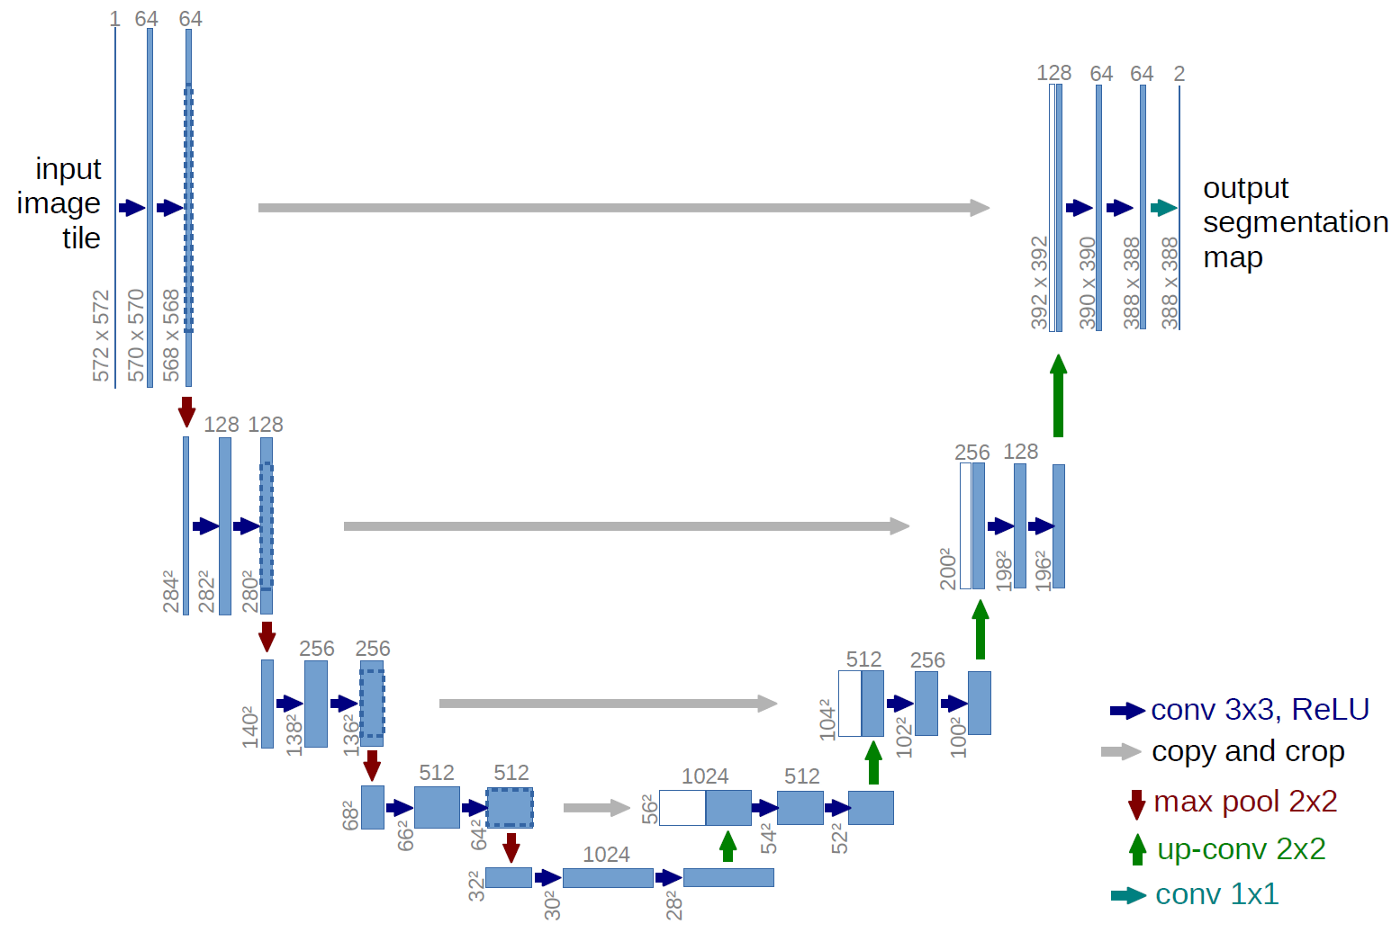


However I didn't use the in [1] proposed weighted pixel cross entropy loss, since a normal Dice loss seems to work just fine in our problem setting and is way simpler to implement. 

I decided to train the network using heavy data augmentation, because there where only 25 images to train on. Each image consitsts of 4 channels - the usual RBG channels as well as the mask channel, which tells wheter or not a part of the image is blacked out. I suppose this is done for reasons of privacy or similar. 

Sadly there is one image which has a wrong mask, so only 24 images remain for training and validation. I splited the data so that 8 images are used for validation and 16 images are used for training. With the help of image augmentation I increased the dataset size, so that there are 1000 images to train on and 250 images to validate against.

Besides from that there is nothing to really write home about. I used Adam since it is overall good performances across different datasets. I didnt do a lot of finetuning nor did I use other architectures. 

I trained 3 different versions of U-NET, with 16 or 32 inital filters respectively. 32 filters appeared to yield the best result. This is not at all representative, since I only trained each of these networks once.

Further improvements could be achieved in different ways. First of all one could try to use an adapted version of Unet, which uses an on imagenet pretrained backbone, to evaluate if this yields in better generalization. A common choice for the back bone would for example be Renet-34 from what I have seen. Secondly different loss functions could be used to enforce for example shaper edge (see [1]). 

Normally my go to choice would have been pytorch lightning since it removes the need for a lot of this boilerplate code seen below, but this time I felt fancy doing the trainig from ground up.

For the Results just jump right to the end of the notebook!

I hope this is sufficient to show you that I am capeable of dealing with Deep Learning and would make a good fit for you firm.

Thats about it. If you have any questions, feel free to write me.

Kind Regards,

Lorenz Hufe

In [21]:
## Change these param to your choice!
DEBUG_training = True
NUM_UNET_FILTER = 32
RETRAIN = False

In [2]:
# Load the weights
!git clone https://github.com/lowlorenz/UnetDidaApplication.git
!mv UnetDidaApplication weights

Cloning into 'UnetDidaApplication'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


## Load the data from the dida Website
Leave out image 278 since the label data is corrupted 

In [3]:
!pip3 install Augmentor > /dev/null
!pip install segmentation_models_pytorch > /dev/null
!pip install pytorch_toolbelt > /dev/null

import requests
import Augmentor
import shutil
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np

In [4]:
!wget https://dida.do/assets/downloads/dida-test-task/dida_test_task.zip
!unzip dida_test_task.zip  > /dev/null

!mkdir test_images train_images train_labels validation_images validation_labels augmented_labels augmented_validation_labels
!mv images/535.png images/537.png images/539.png images/551.png images/553.png ./test_images

!mv images/121.png images/241.png images/270.png images/272.png images/274.png images/284.png images/287.png images/300.png images/301.png images/303.png images/308.png images/314.png images/315.png images/317.png images/320.png images/324.png train_images
!mv labels/121.png labels/241.png labels/270.png labels/272.png labels/274.png labels/284.png labels/287.png labels/300.png labels/301.png labels/303.png labels/308.png labels/314.png labels/315.png labels/317.png labels/320.png labels/324.png train_labels
!mv images/328.png images/337.png images/343.png images/345.png images/379.png images/381.png images/417.png images/532.png validation_images
!mv labels/328.png labels/337.png labels/343.png labels/345.png labels/379.png labels/381.png labels/417.png labels/532.png validation_labels

--2021-03-07 12:08:11--  https://dida.do/assets/downloads/dida-test-task/dida_test_task.zip
Resolving dida.do (dida.do)... 167.71.34.33
Connecting to dida.do (dida.do)|167.71.34.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4768056 (4.5M) [application/zip]
Saving to: ‘dida_test_task.zip’

dida_test_task.zip  100%[===================>]   4.55M  5.29MB/s    in 0.9s    

2021-03-07 12:08:13 (5.29 MB/s) - ‘dida_test_task.zip’ saved [4768056/4768056]



## Use image augmentation on training data

In [5]:

### AUGMENT THE TRAINING DATA
p = Augmentor.Pipeline('train_images', output_directory='augmented_images')
p.ground_truth('train_labels')

p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
p.flip_left_right(probability=0.5)
p.flip_top_bottom(probability=0.5)
p.skew(probability=0.3)
p.crop_random(0.5, percentage_area=0.7)
p.resize(1, 256, 256)
p.sample(1000)

# move the files into the local directory
!mv train_images/augmented_images ./augmented_images

# rename the files and split the generated labels and images into seperate folder 
for file in os.listdir('augmented_images/'):
  new_name = file.split('_')[-1]
  if 'original' in file:
    shutil.move('augmented_images/' + file, 'augmented_images/' + new_name)
  if 'groundtruth' in file:
    shutil.move('augmented_images/' + file, 'augmented_labels/' + new_name)

Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to train_images/augmented_images.16 ground truth image(s) found.


Processing <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FAFFDAFEE90>: 100%|██████████| 1000/1000 [00:41<00:00, 24.09 Samples/s]


## Apply the augmentation on the validation data

In [6]:
# same as above but with the validation data
p = Augmentor.Pipeline('validation_images', output_directory='augmented_validation_images')
p.ground_truth('validation_labels')

p.random_distortion(probability=0.4, grid_width=4, grid_height=4, magnitude=4)
p.flip_left_right(probability=0.5)
p.flip_top_bottom(probability=0.5)
p.skew(probability=0.3)
p.crop_random(0.2, percentage_area=0.8)
p.resize(1, 256, 256)
p.sample(200)

!mv validation_images/augmented_validation_images ./augmented_validation_images

for file in os.listdir('augmented_validation_images/'):
  new_name = file.split('_')[-1]
  if 'original' in file:
    shutil.move('augmented_validation_images/' + file, 'augmented_validation_images/' + new_name)
  if 'groundtruth' in file:
    shutil.move('augmented_validation_images/' + file, 'augmented_validation_labels/' + new_name)

Executing Pipeline:   0%|          | 0/200 [00:00<?, ? Samples/s]

Initialised with 8 image(s) found.
Output directory set to validation_images/augmented_validation_images.8 ground truth image(s) found.


Processing <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FAFF74D1290>: 100%|██████████| 200/200 [00:07<00:00, 27.94 Samples/s]


## Build the dataset


In [7]:
class SegmentationDataset(Dataset):
  
    def __init__(self, img_path, segmentation_path, mean=0, std=1, preprocessor=None):
        self.X = []
        self.Y = []
        
        # load image paths
        for image_file in os.listdir(img_path):
            self.X.append(img_path + image_file)
            self.Y.append(segmentation_path + image_file)

        self.tr_y = transforms.ToTensor()
        self.tr_x = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)      
        ]) 
        self.preprocessor = preprocessor
    
    def __getitem__(self, index):
        x = Image.open(self.X[index])
        x = self.tr_x(x)
        if self.preprocessor:
          x = self.preprocessor(x)
        
        y = Image.open(self.Y[index])
        y = self.tr_y(y)
        
        return x, y

    def __len__(self):
        return len(self.X) 

Calculate mean and std for the z normalization

In [8]:
# calcualte the mean and std of some representation image
tmp_data = SegmentationDataset('augmented_images/', 'augmented_labels/')
loader = DataLoader(tmp_data, batch_size=len(tmp_data), num_workers=1)
data = next(iter(loader))
mean, std = data[0].mean(), data[0].std()

Create the data loader

In [9]:
train_data = SegmentationDataset('augmented_images/', 'augmented_labels/', mean=mean, std=std)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=12)

validation_data = SegmentationDataset('augmented_validation_images/', 'augmented_validation_labels/', mean=mean, std=std)
validation_loader = DataLoader(validation_data, batch_size=4, shuffle=False, num_workers=4)

## Show the data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


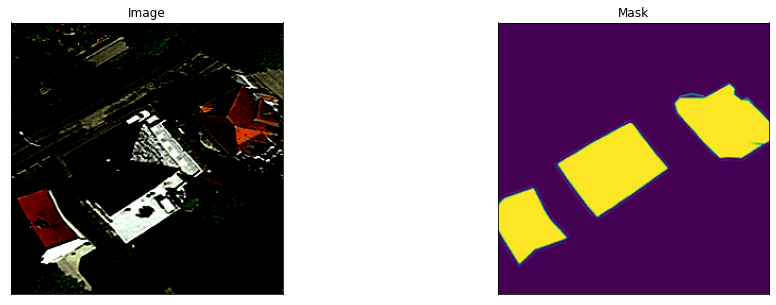

In [10]:
# helper function for data visualization
def visualize(safe=False, filename='out.png', **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        if type(image.size) == int:
          image = image.unsqueeze()
        
        if image.size()[0] == 4:
            image = image.permute(1,2,0)

        if image.size()[0] == 3:
            image = image.permute(1,2,0)
        elif image.size()[0] == 1:
            image = image.squeeze()

        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if safe:
      plt.savefig(filename)
    plt.show()

# exemplary use case  
image, mask = train_data[0] 
visualize(
    image=image, 
    mask=mask.squeeze()
)

## Build the model


In [23]:
# Get the device  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Use the device: {device}')

Use the device: cuda


In [24]:
# define the model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=4, out_channels=1, init_features=NUM_UNET_FILTER).to(device)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [25]:
## define the loss
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # calculate dice loss = (2*union)/(union + intersection) 
        # dice is the equivalent of the F1 score
        union = torch.sum(targets*inputs)
        union_and_intersection = torch.sum(targets+inputs)
        dice = 2*union/union_and_intersection
                       
        return 1 - dice

dice = DiceLoss()

def UnionOverIntersection(inputs, targets):
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    union = torch.sum(targets*inputs)
    intersection = torch.sum(targets+inputs) - union

    return union/intersection

## Adam is a fine goto choice when it comes to optimizers
optim = torch.optim.Adam(model.parameters(), lr=0.001)

Train the network!


In [ ]:
if RETRAIN:
  min_validation_loss = 1
  time_since_last_improvement = 0
  epoch = 0

  while time_since_last_improvement < 40:

    avg_loss = 0
    i=0
    for image, label in train_loader:

      image = image.to(device)
      label = label.to(device)
      prediction = model(image)
      loss = dice(prediction, label)
      loss.backward()
      optim.step()
      optim.zero_grad()
      avg_loss += loss
      i+=1
    avg_loss /= i
    
    if DEBUG_training:
      print(f'Epoch {epoch} - Train Loss: {avg_loss}')

    avg_val_loss = 0
    avg_val_UoI = 0
    i_val=0
    
    with torch.no_grad():
      for image, label in validation_loader:
        image = image.to(device)
        label = label.to(device)
        prediction = model(image)
        loss = dice(prediction, label)
        avg_val_loss += loss 
        avg_val_UoI += UnionOverIntersection(prediction, label)
        i_val+=1
      
    avg_val_loss /= i_val
    avg_val_UoI /= i_val
    if DEBUG_training:
      print(f'\tValidation Loss: {avg_val_loss} - Union over intersection {avg_val_UoI}')

    if avg_val_loss < min_validation_loss:
      time_since_last_improvement = 0
      min_validation_loss = avg_val_loss
      torch.save(model.state_dict(), f'weights/unet_{NUM_UNET_FILTER}')
      
      if DEBUG_training:
        print(f'Safe the model')
    else:
      time_since_last_improvement += 1

    epoch += 1
  print('Training is done')

Epoch 0 - Train Loss: 0.538798987865448
	Validation Loss: 0.547583281993866 - Union over intersection 0.2934475541114807
Safe the model
Epoch 1 - Train Loss: 0.4143023192882538
	Validation Loss: 0.46813902258872986 - Union over intersection 0.3637951612472534
Safe the model
Epoch 2 - Train Loss: 0.313336580991745
	Validation Loss: 0.35406115651130676 - Union over intersection 0.47891539335250854
Safe the model
Epoch 3 - Train Loss: 0.22179242968559265
	Validation Loss: 0.28389057517051697 - Union over intersection 0.5605413913726807
Safe the model
Epoch 4 - Train Loss: 0.17497006058692932
	Validation Loss: 0.27854299545288086 - Union over intersection 0.5669217109680176
Safe the model
Epoch 5 - Train Loss: 0.15094949305057526
	Validation Loss: 0.26550984382629395 - Union over intersection 0.5839409828186035
Safe the model
Epoch 6 - Train Loss: 0.12802404165267944
	Validation Loss: 0.26058411598205566 - Union over intersection 0.5901854634284973
Safe the model
Epoch 7 - Train Loss: 0.11

In [15]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=4, out_channels=1, init_features=NUM_UNET_FILTER).to(device)
model.load_state_dict(torch.load(f'weights/unet_{NUM_UNET_FILTER}'))

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

## Visualize the results

Because of the mask channel in the image files the image gets interpreted as an alpha channel (RGBA picture) therefore the training and validation images seem a little darker then they are. In the test data however I explicitly load them as RBG images for the visualization.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 256, 256])


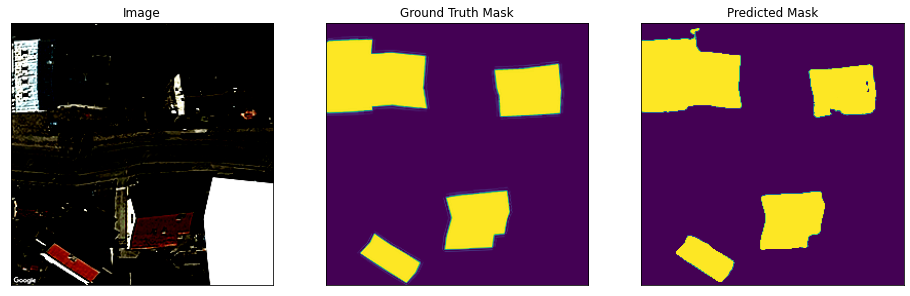

torch.Size([1, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


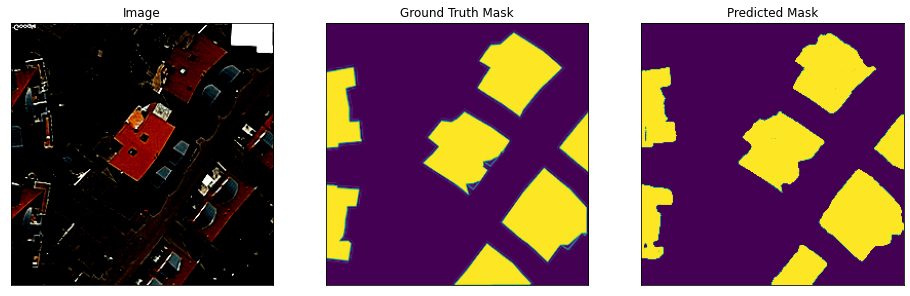

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 256, 256])


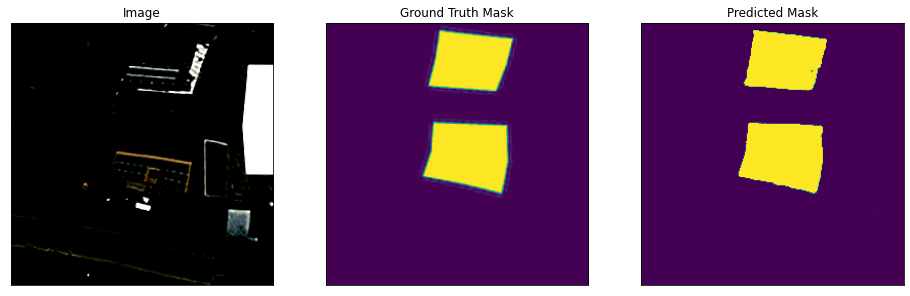

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 256, 256])


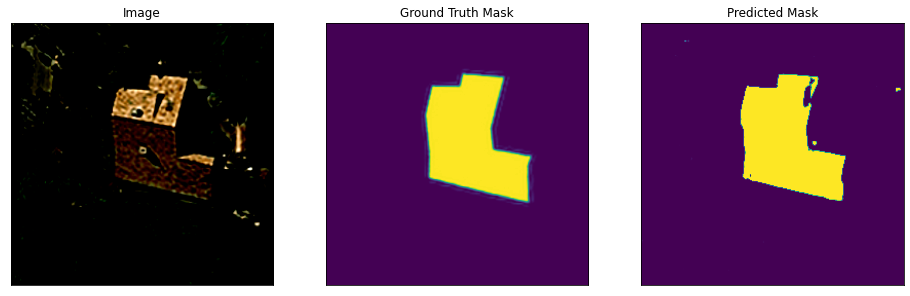

torch.Size([1, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


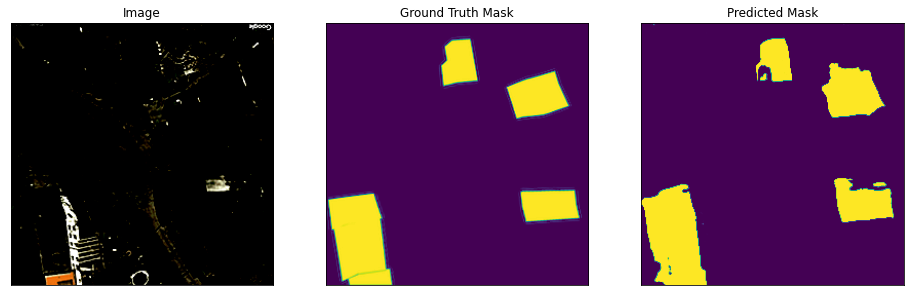

In [16]:
for i in range(5):
  with torch.no_grad():
    n = np.random.choice(len(train_data))
    
    image, mask = train_data[n]
    mask = mask.squeeze()
    
    x_tensor = image.to('cuda').unsqueeze(0)
    pr_mask = model(x_tensor)
    print(pr_mask.size())
    pr_mask = pr_mask.squeeze().cpu()
    visualize(
        image=image, 
        ground_truth_mask=mask, 
        predicted_mask=pr_mask
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


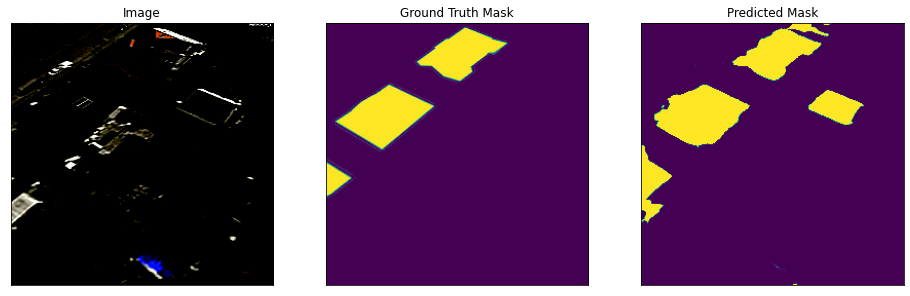

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


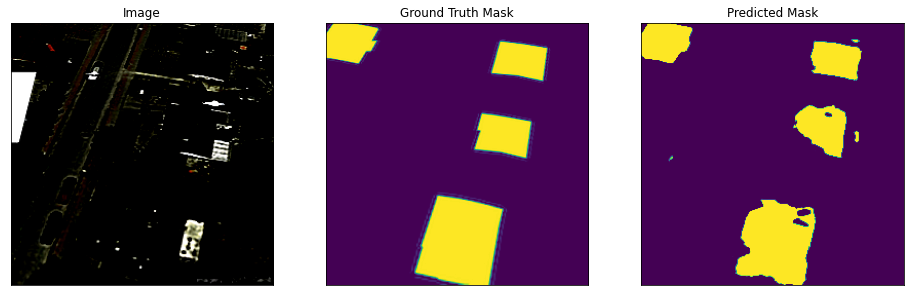

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


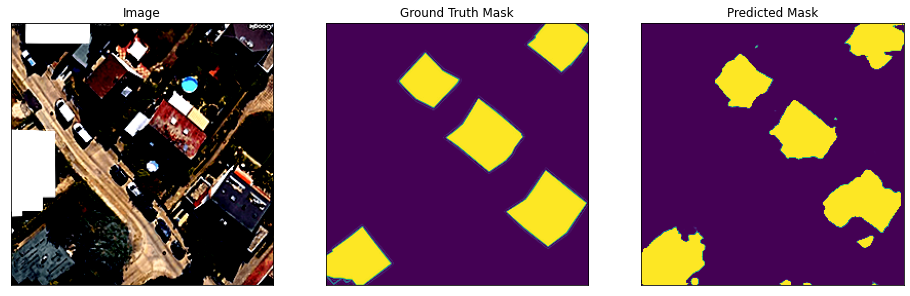

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


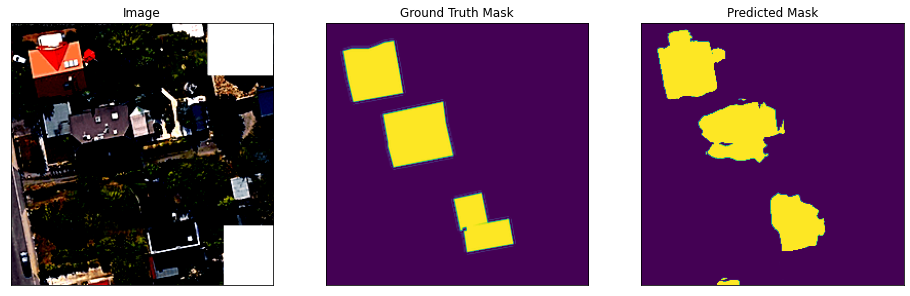

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


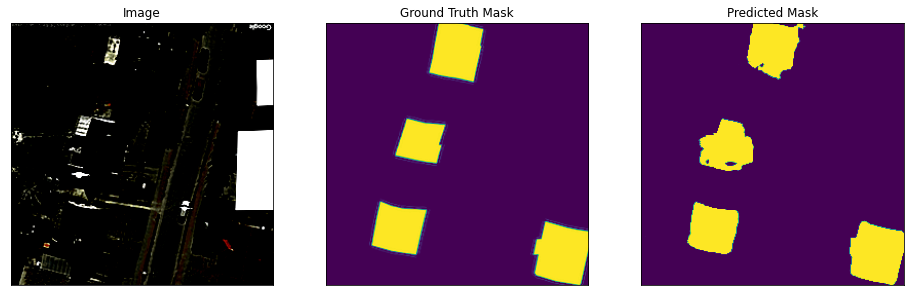

In [17]:
for i in range(5):
  with torch.no_grad():
    n = np.random.choice(len(validation_data))
    
    image, mask = validation_data[n]
    mask = mask.squeeze()
    
    x_tensor = image.to('cuda').unsqueeze(0)
    pr_mask = model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu()
        
    visualize(
        image=image, 
        ground_truth_mask=mask, 
        predicted_mask=pr_mask
    )

## Final inference on the test data

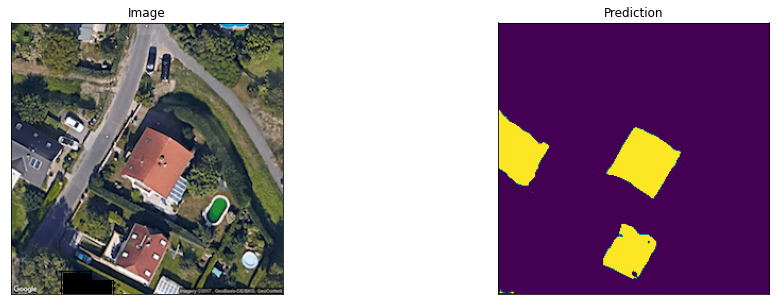

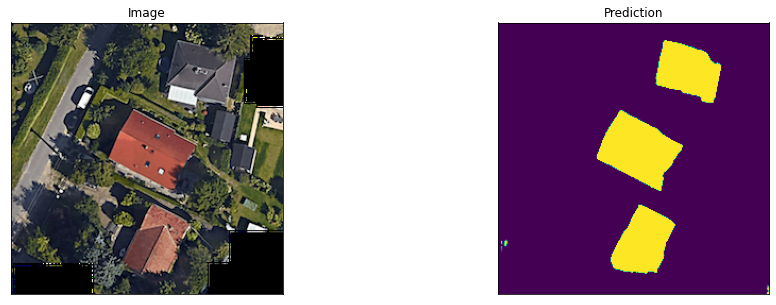

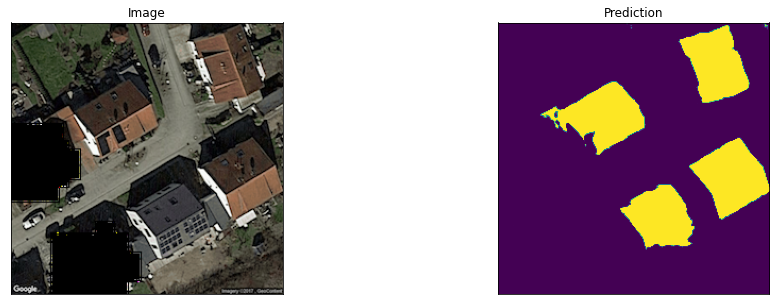

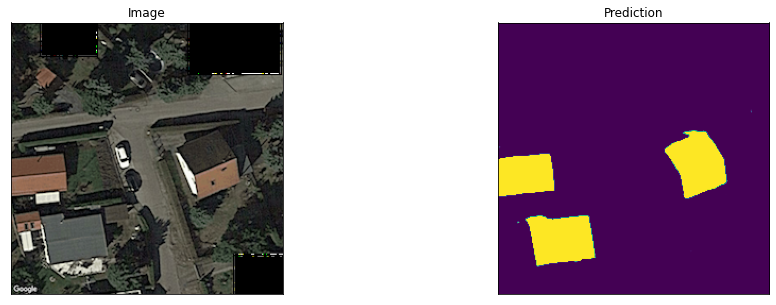

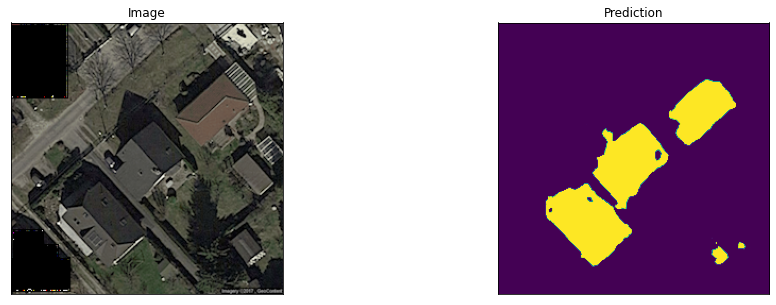

In [18]:
tr = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean, std)      
]) 

img_tr = transforms.ToTensor()

images = [img_tr(Image.open('test_images/' + image_file).convert('RGB')) for image_file in os.listdir('test_images/')]
test = []

for image_file in os.listdir('test_images/'):
  img = tr(Image.open('test_images/' + image_file)).to(device)
  test.append(img)

with torch.no_grad():
  test = torch.stack(test)
  prediction = model(test)
  test = test.to('cpu')
  prediction = prediction.to('cpu')
  for i in range(5):
    visualize(safe=True, filename=f'out_{i}.png', image=images[i], prediction=prediction[i])